# **Attrition Risk Modeling**
<br/>by Christian Fernandes

Dataset: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset?resource=download

To leave or not to leave? That is the question many of us in the workforce have probably at least once in our careers considered. Whether it be for chasing that next promotion, improving that work-life balance, or disatisfaction with our current environment, there are many reasons why we'd choose to jump ship. 

Well, what does this mean for the employer? In terms of the bottom line, high attrition could engender a number of issues that include but are certainly not limited to higher costs, decreased workplace morale, and potentially, a snowball effect that leads to more and more turnovers. 

What can employers do? As with any problem, the first thing that needs to be done is to identify the problem and in many cases, that could be hardest part because they are many, many reasons that underpin turnover in the workplace.<br/> 

Simply put, companies need to take advantage of the employee data that is at their fingertips while also ensuring that employee data is protected and secured with utmost integrity. 

Here are some things to consider:
<ul>
    <li> Using geospatial information like addresses, we can pair this data with employee HQ location data to determine the commuting distance for employees. If we pair this with a flag that identifies remote versus in-office employees then we can see how turnover effects the former versus the latter. </li>
    <li> Using employee start dates and the current date, we could determine the length of service for a given employee and see if this could serve as a proxy for a lack of upward mobility. </li>
    <li> Using age information, could it be the case that younger employees are more prone to job hop in today's market? For employees at retirement age, what does turnover look like for this group?</li>
</ul>

## Reading in the data

In [1]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
empattr = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [4]:
empattr.sample(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
495,27,Yes,Travel_Rarely,1420,Sales,2,1,Marketing,1,667,...,2,80,1,5,3,3,4,3,0,2
494,34,No,Travel_Rarely,204,Sales,14,3,Technical Degree,1,666,...,4,80,2,8,3,3,8,2,0,6
1061,24,No,Non-Travel,830,Sales,13,2,Life Sciences,1,1495,...,3,80,1,1,2,3,1,0,0,0


In [5]:
empattr.shape

(1470, 35)

The dataset has 35 variables and 1470 observations. Several things we need to be aware of: 
<ul> 
    <li> Small sample sizes in general can lead to instability in our model parameter estimates </li>
    <li> Ideally, our response variable should be an i.i.d random variable otherwise, any predictions made from this data could be way off.
</ul>


In [6]:
empattr.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [7]:
objcols = [c for c in empattr.columns if empattr[c].dtype == 'O']

In [8]:
catcols = ["Education", "EnvironmentSatisfaction", "JobInvolvement", "JobSatisfaction", "PerformanceRating", "RelationshipSatisfaction", "WorkLifeBalance"]

In [9]:
objcols

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [10]:
# Check to see if any of the object type columns are in the categorical column list defined in the IBM metadata
# Result is an empty set
set(objcols).intersection(set(catcols))

set()

## EDA

In [11]:
def plot_hist(tibble, colname, response_var):
    tibble[[colname, response_var]].boxplot(by = response_var, grid = False)

def plot_barchart(series_col):
    """a is pd.Series object that names the column to be converted to a barchart"""
    counterDict = dict(Counter(series_col))
    df = pd.DataFrame({'labels': counterDict.keys(), 'values': counterDict.values()})

    df.plot.bar(x = 'labels', y = 'values', title = series_col.name)
    
def plot_figure(tibble, colname, xlab = None, ylab = None, fig_type = None, response_var = None):
    from collections import Counter
    
    if fig_type:
        if fig_type == 'hist':
            tibble[colname].hist(grid = False)
        elif fig_type == 'boxplot':
            plot_hist(tibble, colname, response_var)
        elif fig_type == 'barh':
            plot_barchart(tibble[colname])

In [12]:
# Descriptive statistics for the categorical data

# First ensure all columns are of the 'object' type - similar to R's as.factor() command
empattr_obj = empattr[objcols + catcols].astype(object)

In [13]:
empattr_obj.describe()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime,Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance
count,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,1,2,5,4,4,4,2,4,4
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No,3,3,3,4,3,3,3
freq,1233,1043,961,606,882,326,673,1470,1054,572,453,868,459,1244,459,893


Already, we can see for some of the observations that a majority of the employees in this dataset did not quit their jobs (Attrition = No). We can also see that a large proportion of observations are male employees (they make up a majority relative to the other gender 'female').   

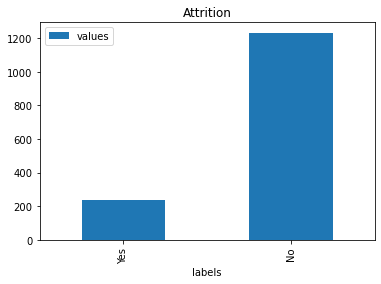

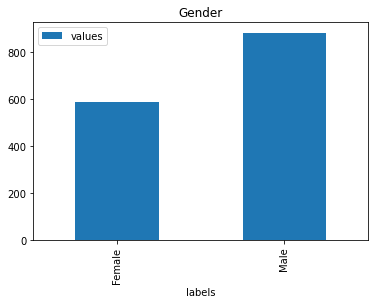

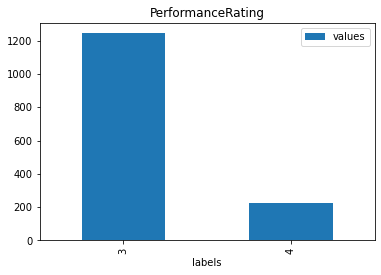

In [14]:
printcols = ['Attrition', 'Gender', 'PerformanceRating']
for c in printcols:
    plot_figure(empattr, c,  xlab = c, ylab = None, fig_type = 'barh')

In [15]:
# Descriptive statistics for the numerical data

# Grabbing all of the columns that were not identified as categorical (not in the empattr_obj dataframe)
empattr_numerical_cols = list(set(empattr.columns.tolist()).difference(set(objcols + catcols)))

In [16]:
empattr[empattr_numerical_cols].describe()

,TotalWorkingYears,YearsAtCompany,DistanceFromHome,YearsInCurrentRole,YearsWithCurrManager,MonthlyRate,JobLevel,Age,MonthlyIncome,DailyRate,NumCompaniesWorked,HourlyRate,StandardHours,PercentSalaryHike,EmployeeNumber,YearsSinceLastPromotion,TrainingTimesLastYear,EmployeeCount,StockOptionLevel
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000
mean,11.279592,7.008163,9.192517,4.229252,4.123129,14313.103401,2.063946,36.923810,6502.931293,802.485714,2.693197,65.891156,80.0,15.209524,1024.865306,2.187755,2.799320,1.0,0.793878
std,7.780782,6.126525,8.106864,3.623137,3.568136,7117.786044,1.106940,9.135373,4707.956783,403.509100,2.498009,20.329428,0.0,3.659938,602.024335,3.222430,1.289271,0.0,0.852077
min,0.000000,0.000000,1.000000,0.000000,0.000000,2094.000000,1.000000,18.000000,1009.000000,102.000000,0.000000,30.000000,80.0,11.000000,1.000000,0.000000,0.000000,1.0,0.000000
25%,6.000000,3.000000,2.000000,2.000000,2.000000,8047.000000,1.000000,30.000000,2911.000000,465.000000,1.000000,48.000000,80.0,12.000000,491.250000,0.000000,2.000000,1.0,0.000000
50%,10.000000,5.000000,7.000000,3.000000,3.000000,14235.500000,2.000000,36.000000,4919.000000,802.000000,2.000000,66.000000,80.0,14.000000,1020.500000,1.000000,3.000000,1.0,1.000000
75%,15.000000,9.000000,14.000000,7.000000,7.000000,20461.500000,3.000000,43.000000,8379.000000,1157.000000,4.000000,83.750000,80.0,18.000000,1555.750000,3.000000,3.000000,1.0,1.000000
max,40.000000,40.000000,29.000000,18.000000,17.000000,26999.000000,5.000000,60.000000,19999.000000,1499.000000,9.000000,100.000000,80.0,25.000000,2068.000000,15.000000,6.000000,1.0,3.000000


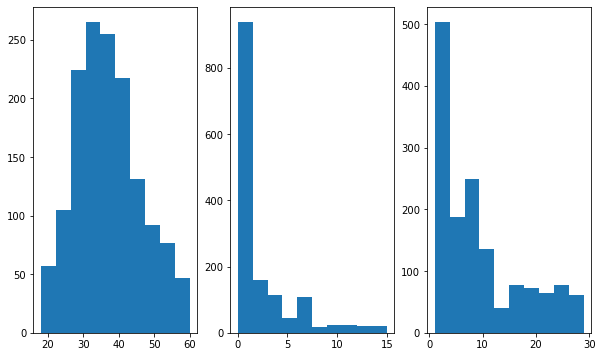

In [17]:
fig, ax = plt.subplots(1,3, figsize = (10, 6))
plt.subplot(1,3,1)
plot_figure(empattr, 'Age', 'Age', None, 'hist')
plt.subplot(1,3,2)
plot_figure(empattr, 'YearsSinceLastPromotion', 'YearsSinceLastPromotion', None, 'hist')
plt.subplot(1,3,3)
plot_figure(empattr, 'DistanceFromHome', 'DistanceFromHome', None, 'hist')

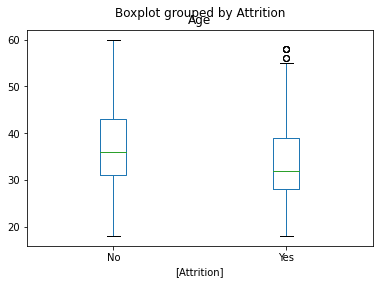

In [18]:
plot_figure(empattr, 'Age', fig_type = 'boxplot', response_var = 'Attrition')

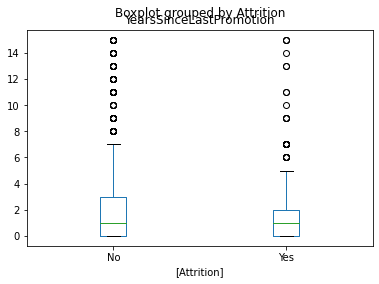

In [19]:
plot_figure(empattr, 'YearsSinceLastPromotion', fig_type = 'boxplot', response_var = 'Attrition')

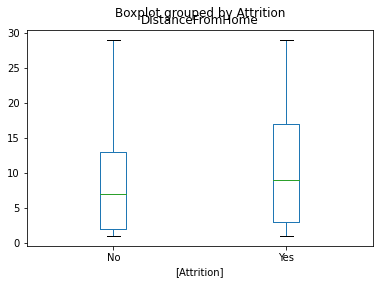

In [20]:
plot_figure(empattr, 'DistanceFromHome', fig_type = 'boxplot', response_var = 'Attrition')

Boxplots allow us to see the center and spread of our data across groups. In the graphs above, we looked at the relationship of the response, Attrition, with the three predictors of interest to see if any appear to have a noticeable relationship. Age and DistanceFromHome both seem to have slightly different centers and roughly proportional spread (possible relationship?). 

However, we have to keep in mind that these plots show us the individual bivariate relationship between attrition and each predictor. In a multiple regression setting (whether it be linear, poisson, logistic, etc.), we also have to be aware of the effects of multicollinearity and how it could impact the sign, size, and significance of our estimates. 

Let's suppose that the variables age, YearsSinceLastPromotion, and DistanceFromHome would all provide predictive power  for whether or not an employee will leave the company. 

We can run a logistic regression model using these three variables and assess if the model provides accurate predictions. 

Otherwise, if not we can potentially consider a full model with all of the available predicting variables and see if a test for a subset of coefficients would be statistically significant.

If so, then we can proceed with using variable selection techniques to find the best subset of coefficients that yield accurate predictions subject to AIC, BIC, or Mallow's Cp.

# Logistic Regression

In Logistic Regression, we assume three things, 
<br/>
<ul>
  <li>The logit of our response variable (the log odds) are a linear combination of our predictors and their coefficients</li>
  <li>Our responses are independent random variables</li>
  <li>Our link function is the logit function (the log odds) since it is possible to use other link functions like the probit function etc.</li>
</ul>

## Submodel with full data

In [21]:
modelformula = 'Attrition ~ Age + YearsSinceLastPromotion + DistanceFromHome'

In [22]:
smf_model = smf.glm(formula = modelformula, data=empattr, family=sm.families.Binomial())
result = smf_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                          
===============================================================================================
Dep. Variable:     ['Attrition[No]', 'Attrition[Yes]']   No. Observations:                 1470
Model:                                             GLM   Df Residuals:                     1466
Model Family:                                 Binomial   Df Model:                            3
Link Function:                                   logit   Scale:                          1.0000
Method:                                           IRLS   Log-Likelihood:                -625.05
Date:                                 Fri, 06 May 2022   Deviance:                       1250.1
Time:                                         11:12:06   Pearson chi2:                 1.53e+03
No. Iterations:                                      5                                         
Covariance Type:                             nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0274      0.318      0.086      0.931      -0.595       0.650
Age                         0.0529      0.009      5.881      0.000       0.035       0.071
YearsSinceLastPromotion    -0.0027      0.025     -0.108      0.914      -0.051       0.046
DistanceFromHome           -0.0258      0.009     -3.034      0.002      -0.043      -0.009
===========================================================================================
"""

Given an $\alpha$ threshold of 0.05, we can see that all the p-values for the three chosen predictors are indeed less than the threshold and therefore statistically significant.

## Divide up the data intro training and test sets

In [24]:
# Re-map the Yes's to 1s and No's to 0s
# response = empattr['Attrition'].apply(lambda x: 1 if x.upper() == 'YES' else 0)

In [25]:
predictors = empattr[['Age', 'YearsSinceLastPromotion', 'DistanceFromHome']]

In [26]:
response = empattr[['Attrition']]

In [27]:
# Splitting the dataset into training and testing set
xtrain, xtest, ytrain, ytest = train_test_split(predictors, response, test_size = 0.2, random_state = 0)

In [28]:
# Merging the training predictor variables back with the training response variables (because out smf.glm() model 
# will be referencing both)
xtrain2 = xtrain.merge(ytrain, left_index = True, right_index = True)

In [29]:
smf_model_train = smf.glm(formula = modelformula, data=xtrain2, family=sm.families.Binomial())

In [30]:
smf_model_train_result = smf_model_train.fit()

In [31]:
smf_model_train_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                          
===============================================================================================
Dep. Variable:     ['Attrition[No]', 'Attrition[Yes]']   No. Observations:                 1176
Model:                                             GLM   Df Residuals:                     1172
Model Family:                                 Binomial   Df Model:                            3
Link Function:                                   logit   Scale:                          1.0000
Method:                                           IRLS   Log-Likelihood:                -494.31
Date:                                 Fri, 06 May 2022   Deviance:                       988.62
Time:                                         11:12:06   Pearson chi2:                 1.24e+03
No. Iterations:                                      5                                         
Covariance Type:                             nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.2016      0.360     -0.559      0.576      -0.908       0.505
Age                         0.0592      0.010      5.737      0.000       0.039       0.079
YearsSinceLastPromotion     0.0038      0.029      0.132      0.895      -0.053       0.060
DistanceFromHome           -0.0240      0.010     -2.504      0.012      -0.043      -0.005
===========================================================================================
"""

### Testing for overall regression

In [43]:
from scipy.stats.distributions import chi2

By taking the difference between our null deviance and deviance statistic, we are able to assess whether not the model itself is statistically significant.

Recall that in logistic regression, we maximize the log-likelihood function under the model with no parameters (so intercept only) and we maximize the log-likelihood function under the model with all of the predictors of interest (so Age, DistanceFromHome, and YearsSinceLastPromotion). 

We then take the difference of the two models (so the intercept only model would just be the null deviance) and calculate their differences. This yields a $\chi^2$ statistic with degrees of freedom equal to the number of predictors in our model: 3.

Like the F-test for a multiple linear regression model, the null hypothesis is that all of the coefficient estimates in our full model are 0 versus the alternative hypothesis that **atleast 1** is non-zero.


In [59]:
# Assuming large data
overallpvalue = chi2.sf(smf_model_train_result.null_deviance - smf_model_train_result.deviance, 3)

print(f"""Our p-value is {overallpvalue}. \n 
This is much lower than the typical alpha threshold of 0.05. At this level, our model is statiscally significant 
because atleast one of the predictors included in the model has explanatory power with respect to Attrition""")
# Alternative way to comput the p(chi^2 > smf_model_train_result.null_deviance - smf_model_train_result.deviance)
# 1-chi2.cdf(smf_model_train_result.null_deviance - smf_model_train_result.deviance, 3)

Our p-value is 9.457764088890004e-10. 
 
This is much lower than the typical alpha threshold of 0.05. At this level, our model is statiscally significant 
because atleast one of the predictors included in the model has explanatory power with respect to Attrition


In [32]:
# Getting the fitted values from the training set
fitted_xtrain2 = smf_model_train_result.fittedvalues

# Recoding the results (probabilities) into 0 for No and 1 for Yes
fitted_xtrain2_recoded = fitted_xtrain2.apply(lambda x: 0 if x > 0.5 else 1)

In [33]:
# Getting a quick look at the number of Nos (0) and Yes (1)
Counter(ytrain['Attrition'].to_list())

Counter({'No': 988, 'Yes': 188})

In [34]:
# The # of No's and Yes's in the fitted_xtrain_recoded set given our threshold above which was 0.5
Counter(fitted_xtrain2_recoded)

Counter({0: 1176})

The model with just the three predictors - age, distance from home, and years since last promotion- predicted all of the values to be "no". In other words, it predicted 988/(988+188) or 84% of the values correctly. 

## Making a prediction

In [37]:
predictions_test = smf_model_train_result.predict(xtest)

In [38]:
# Apply a threshold 

# Assuming 50/50 chance

th = 0.5

predictions_results = predictions_test.apply(lambda x: 0 if x > th else 1)

In [39]:
Counter(predictions_results)

Counter({0: 294})

In [40]:
Counter(ytest['Attrition'].to_list())

Counter({'No': 245, 'Yes': 49})

In [47]:
predictions_results_recoded = predictions_results.apply(lambda x: 'No' if x == 0 else 'Yes')

In [48]:
Counter(predictions_results_recoded)

Counter({'No': 294})

Our model predicted all of the values to be 'No' in this situation (similar to its behavior with our training set). Effectively, that means that our predictions were 83% accurate. In machine learning, we would expect to see similar results as we move from our training sample to our testing sample when we are working with a model with a few predictors. As we add more predictor variables to the dataset, we might end up with a more accurate result during the training phase but suffer from poor performance in the testing phase. 